## Goals

This is an example of the current capacities of echopype processing for the EK60 echosounder. Inspired by
https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/ms_PacificHake_EK60_cruisetracks.ipynb

## Description


In [120]:
import fsspec
import numpy as np
import geopandas as gpd
import xarray as xr
import echopype as ep
import echopype.visualize as epviz
import matplotlib.pyplot as plt

from pathlib import Path

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Data import

#### Establish AWS S3 file system connection and generate list of target EK60 .raw files

Access and inspect the publicly accessible NCEI WCSD S3 bucket on the AWS cloud as if it were a local file system. This will be done through the Python fsspec file system and bytes storage interface. We will use fsspec.filesystem.glob (fs.glob) to generate a list of all EK60 .raw data files in the bucket, then filter on file names for target dates of interest.

The directory path on the ncei-wcsd-archive S3 bucket is s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/. All .raw files from the 2017 Hake survey cruise are found here.

We will read data from 2017-07-28

In [6]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")

# print out the last two S3 raw file paths in the list
s3rawfiles[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

In [12]:


raw_files = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728']]) 
]

raw_files = [
    s3path for s3path in raw_files
    if any([f"EK60" in s3path])
]

In [15]:
print(f"There are {len(raw_files)} target raw files available")
raw_files[-1:]

There are 97 target raw files available


['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T235144.raw']

#### Metadata creation

In [17]:
def populate_metadata(ed, raw_fname):
    """
    Manually populate into the "ed" EchoData object 
    additional metadata about the dataset and the platform
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = (
        "2017 Joint U.S.-Canada Integrated Ecosystem and "
        "Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')"
    )
    ed['Top-level'].attrs['title'] = f"{survey_name}, file {raw_fname}"
    ed['Top-level'].attrs['summary'] = (
        f"EK60 raw file {raw_fname} from the {survey_name}, converted to a SONAR-netCDF4 file using echopype."
        "Information about the survey program is available at "
        "https://www.fisheries.noaa.gov/west-coast/science-data/"
        "joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey"
    )

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed['Platform'].attrs['platform_type'] = "Research vessel"
    ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"  # A NOAA ship
    ed['Platform'].attrs['platform_code_ICES'] = "315"

In [21]:
base_dpath = Path('./exports/basic_echopype_processing_ek60')
base_dpath.mkdir(exist_ok=True, parents=True)

converted_dpath = Path(base_dpath / 'hakesurvey_convertedzarr')
converted_dpath.mkdir(exist_ok=True)
calibrated_dpath = (base_dpath / 'hakesurvey_calibratednc')
calibrated_dpath.mkdir(exist_ok=True)

#### Process a single file

In [29]:
raw_fpath = Path(raw_files[1])

ed = ep.open_raw(
            f"s3://{raw_fpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )

# Manually populate additional metadata about the dataset and the platform
populate_metadata(ed, raw_fpath.name)

# Save to converted Zarr format
ed.to_zarr(save_path=converted_dpath, overwrite=True)

In [27]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [36]:
ed.group_map

{'top': {'name': 'Top-level',
  'description': 'contains metadata about the SONAR-netCDF4 file format.',
  'ep_group': None},
 'environment': {'name': 'Environment',
  'description': 'contains information relevant to acoustic propagation through water.',
  'ep_group': 'Environment'},
 'platform': {'name': 'Platform',
  'description': 'contains information about the platform on which the sonar is installed.',
  'ep_group': 'Platform'},
 'nmea': {'name': 'NMEA',
  'description': 'contains information specific to the NMEA protocol.',
  'ep_group': 'Platform/NMEA'},
 'provenance': {'name': 'Provenance',
  'description': 'contains metadata about how the SONAR-netCDF4 version of the data were obtained.',
  'ep_group': 'Provenance'},
 'sonar': {'name': 'Sonar',
  'description': 'contains sonar system metadata and sonar beam groups.',
  'ep_group': 'Sonar'},
 'beam': {'name': 'Beam_group1',
  'description': 'contains backscatter data (either complex samples or uncalibrated power samples) and o

<xarray.Dataset>
Dimensions:        (time1: 17147)
Coordinates:
  * time1          (time1) datetime64[ns] 2017-07-28T00:25:07.070000128 ... 2...
Data variables:
    NMEA_datagram  (time1) <U73 '$SDVLW,4945.293,N,4945.293,N' ... '$INHDT,87...
Attributes:
    description:  All NMEA sensor datagrams

In [82]:
sonar = ed["Sonar/Beam_group1"]
sonar

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 534, beam: 1,
                                    range_sample: 3957)
Coordinates:
  * channel                        (channel) <U37 'GPT  18 kHz 009072058c8d 1...
  * ping_time                      (ping_time) datetime64[ns] 2017-07-28T00:2...
  * range_sample                   (range_sample) int64 0 1 2 ... 3954 3955 3956
  * beam                           (beam) <U1 '1'
Data variables: (12/25)
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    beam_type                      (channel, ping_time) int64 1 1 1 1 ... 1 1 1
    beamwidth_twoway_alongship     (channel, ping_time, beam) float64 10.9 .....
    beamwidth_twoway_athwartship   (channel, ping_time, beam) float64 10.82 ....
    beam_direction_x               (channel, ping_time, beam) float64 0.0 ......
    beam_direction_y               (channel, ping_time, beam) float64 0.0 ......
    ...                             ...
    count                          (channel, ping_time) float64 3.957e+03 ......
    offset                         (channel, ping_time) float64 0.0 0.0 ... 0.0
    transmit_mode                  (channel, ping_time) float64 0.0 0.0 ... 0.0
    backscatter_r                  (channel, ping_time, range_sample, beam) float32 ...
    angle_athwartship              (channel, ping_time, range_sample, beam) float64 ...
    angle_alongship                (channel, ping_time, range_sample, beam) float64 ...
Attributes:
    beam_mode:              vertical
    conversion_equation_t:  type_3

In [85]:
frequencies = sonar['channel']
frequencies

<xarray.DataArray 'channel' (channel: 3)>
array(['GPT  18 kHz 009072058c8d 1-1 ES18-11',
       'GPT  38 kHz 009072058146 2-1 ES38B',
       'GPT 120 kHz 00907205a6d0 4-1 ES120-7C'], dtype='<U37')
Coordinates:
  * channel  (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... 'GPT 1...
Attributes:
    long_name:  Vendor channel ID

We appear to have a three-frequency instrument.

In [88]:
# Compute base SV
ds_Sv = ep.calibrate.compute_Sv(ed)
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 534,
                                    range_sample: 3957, filenames: 1, time3: 534)
Coordinates:
  * channel                        (channel) <U37 'GPT  18 kHz 009072058c8d 1...
  * ping_time                      (ping_time) datetime64[ns] 2017-07-28T00:2...
  * range_sample                   (range_sample) int64 0 1 2 ... 3954 3955 3956
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-07-28T00:25:07...
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.7 ... -0.3
    ...                             ...
    angle_sensitivity_alongship    (channel, ping_time) float64 13.89 ... 23.12
    angle_sensitivity_athwartship  (channel, ping_time) float64 13.89 ... 23.12
    beamwidth_alongship            (channel, ping_time) float64 10.9 ... 6.58
    beamwidth_athwartship          (channel, ping_time) float64 10.82 ... 6.52
    source_filenames               (filenames) <U92 's3://ncei-wcsd-archive/d...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2023-06-26T13:53:26Z
    processing_function:          calibrate.compute_Sv

In [126]:
#Remove background noise
ds_Sv_clean = ep.preprocess.remove_noise(    # obtain a denoised Sv dataset
   ds_Sv,             # calibrated Sv dataset
   range_sample_num=30,  # number of samples along the range_sample dimension for estimating noise
   ping_num=5,        # number of pings for estimating noise
)

ds_Sv_clean

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 534,
                                    range_sample: 3957, filenames: 1, time3: 534)
Coordinates:
  * channel                        (channel) <U37 'GPT  18 kHz 009072058c8d 1...
  * ping_time                      (ping_time) datetime64[ns] 2017-07-28T00:2...
  * range_sample                   (range_sample) int64 0 1 2 ... 3954 3955 3956
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-07-28T00:25:07...
Data variables: (12/18)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.7 ... -0.3
    ...                             ...
    beamwidth_alongship            (channel, ping_time) float64 10.9 ... 6.58
    beamwidth_athwartship          (channel, ping_time) float64 10.82 ... 6.52
    source_filenames               (filenames) <U92 's3://ncei-wcsd-archive/d...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
    Sv_noise                       (channel, ping_time, range_sample) float64 ...
    Sv_corrected                   (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2023-06-26T14:47:26Z
    processing_function:          clean.remove_noise

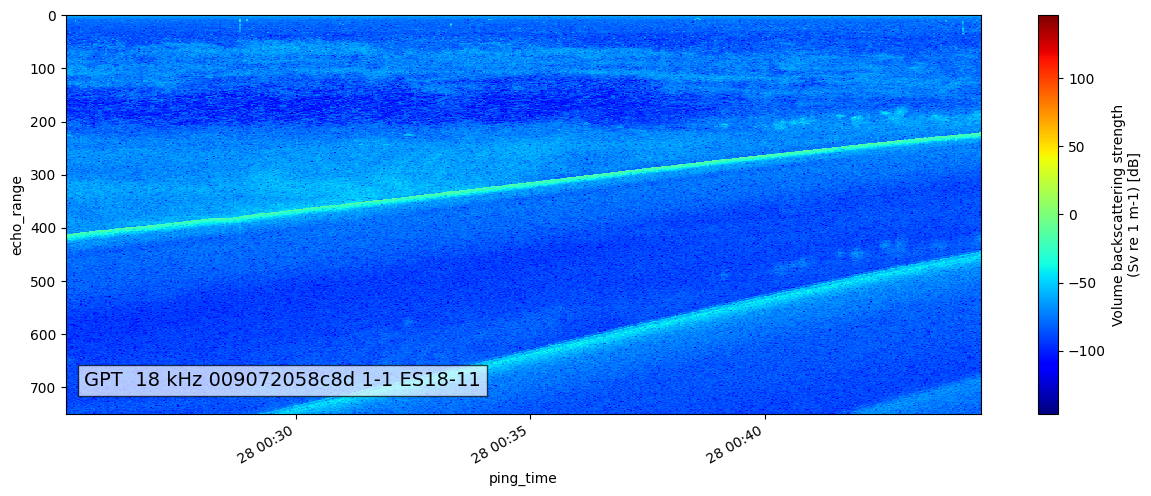

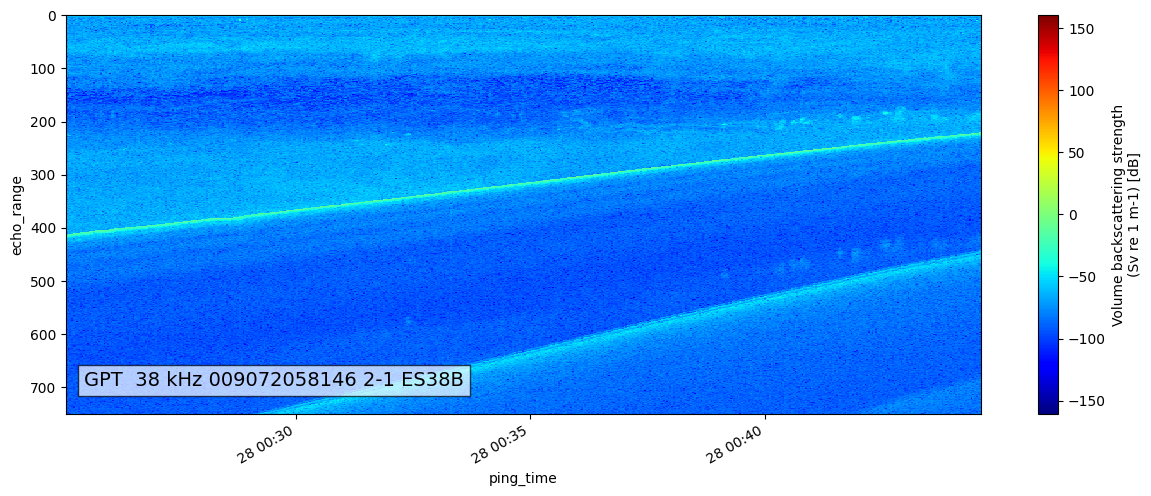

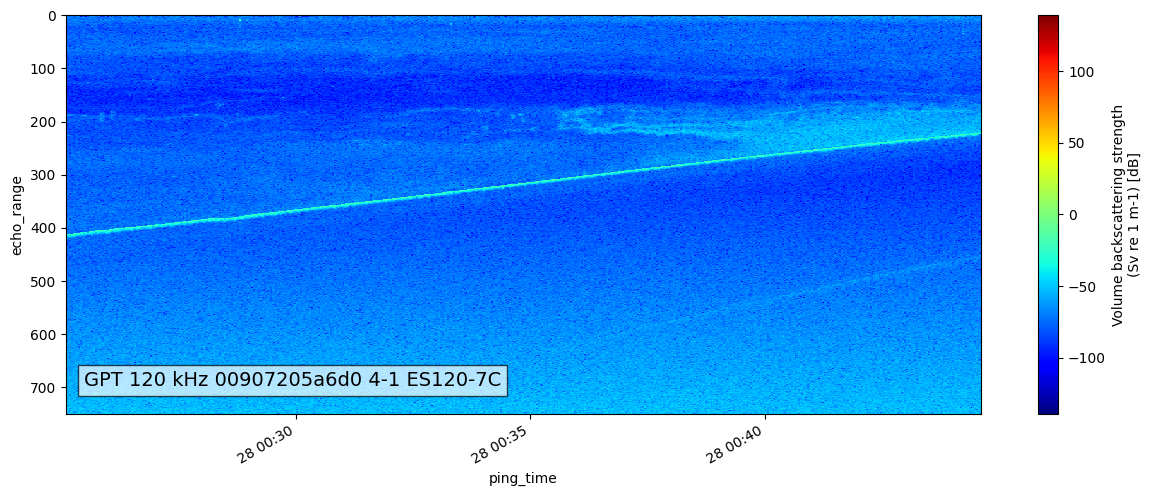

In [130]:
#Let's visualise this
epviz.create_echogram(ds_Sv_clean)

Let's try searching for krill. This is done by creating a mask that only keeps points with a Sv difference between 2 and 16 dB between the 120 and the 38 kHz channels


In [135]:
low_mask = ep.mask.frequency_differencing(source_Sv=ds_Sv_clean, storage_options={}, freqAB=None,
                                     chanAB = [
                                         'GPT 120 kHz 00907205a6d0 4-1 ES120-7C',
                                         'GPT  38 kHz 009072058146 2-1 ES38B'
                                     ],
                                     operator = ">=", diff=2.0)

high_mask = ep.mask.frequency_differencing(source_Sv=ds_Sv_clean, storage_options={}, freqAB=None,
                                     chanAB = [
                                         'GPT 120 kHz 00907205a6d0 4-1 ES120-7C',
                                         'GPT  38 kHz 009072058146 2-1 ES38B'
                                     ],
                                     operator = "<=", diff=16.0)
       
krill_mask = low_mask & high_mask
krill_mask

<xarray.DataArray 'mask' (ping_time: 534, range_sample: 3957)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2017-07-28T00:25:07.070000128 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3952 3953 3954 3955 3956

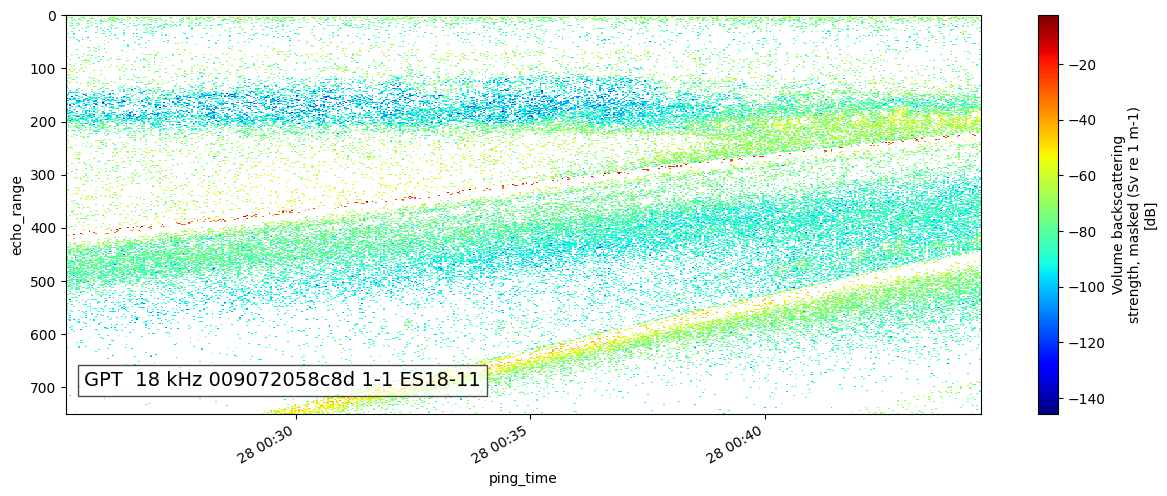

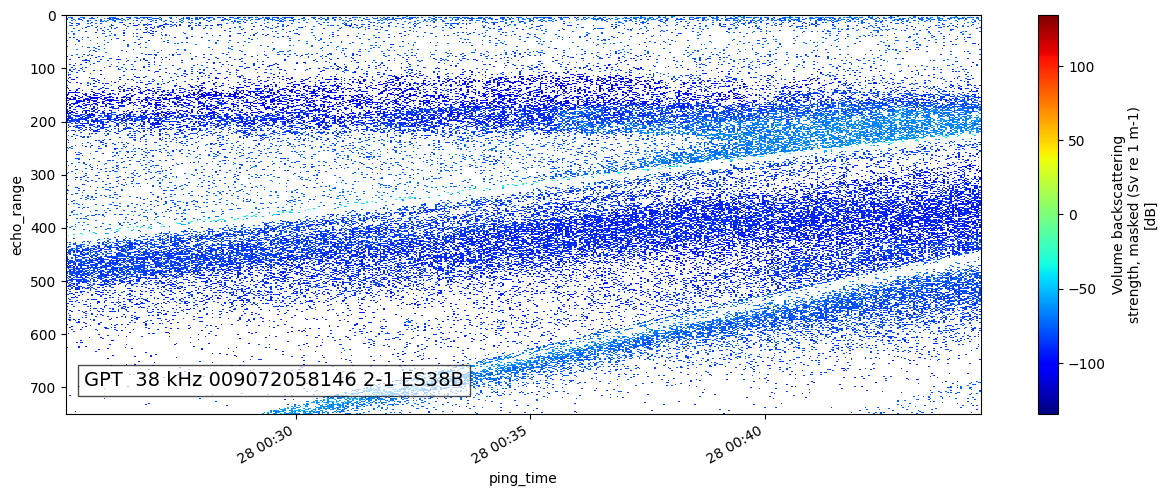

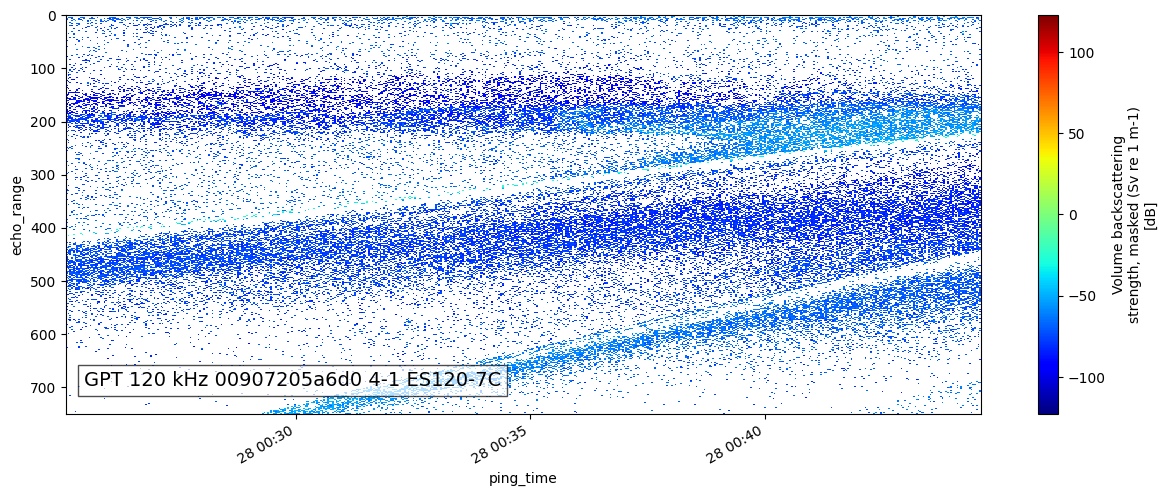

In [137]:
masked = ep.mask.apply_mask(ds_Sv_clean, krill_mask)
epviz.create_echogram(masked)